## Important 
you need to run the notebook within xvfb (x virtual frame buffer)
`xvfb-run -s "-screen 0 1400x900x24" jupyter notebook`

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from IPython.display import IFrame
from include_pycharm_modules import import_source_folders
import_source_folders("/home/kic/sources/private/projects/pandas-quant")

adding module /home/kic/sources/private/projects/pandas-quant/pandas-ml-common
adding module /home/kic/sources/private/projects/pandas-quant/pandas-ml-quant
adding module /home/kic/sources/private/projects/pandas-quant/pandas-ml-utils
adding module /home/kic/sources/private/projects/pandas-quant/pandas-ml-1ntegration-test
adding module /home/kic/sources/private/projects/pandas-quant/pandas-ml-quant-data-provider
adding module /home/kic/sources/private/projects/pandas-quant/pandas-ml-quant-rl


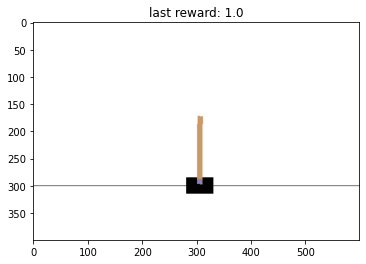

((array([ 0.04591225,  0.14659626,  0.00722724, -0.25092284]),
  array([], dtype=float64)),
 1.0,
 False,
 {})

In [2]:
from pandas_ml_quant_rl.model.environments import CartPoleWrappedEnv
import numpy as np

env = CartPoleWrappedEnv(auto_render_after_steps=100)

s = env.reset()
env.render()
env.step(np.random.choice(env.action_space.n))

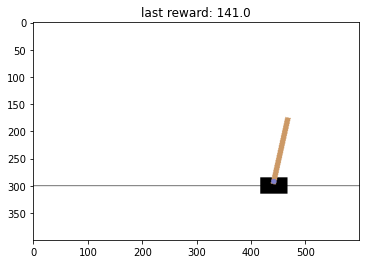

Solved 101.79920807164407 in 549 episodes


In [3]:
import torch.nn as nn
from pandas_ml_quant_rl.model.agent import PolicyNetwork
from pandas_ml_quant_rl.model.agent import ReinforceAgent

class Net(PolicyNetwork):
    
    def __init__(self, input_size, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, n_actions),
            nn.Softmax()
        )
        
    def estimate_action(self, state, state_2):
        return self.net(state)



agent = ReinforceAgent(
    Net(env.observation_space.shape[0], 2).cpu(),
    exit_criteria=lambda reward, cnt: reward > 100 or cnt > 1500,
    batch_size=10,
    gamma=0.99
)

agent.fit(env)    

In [4]:
IFrame('http://localhost:6006/', width='100%', height='800px')

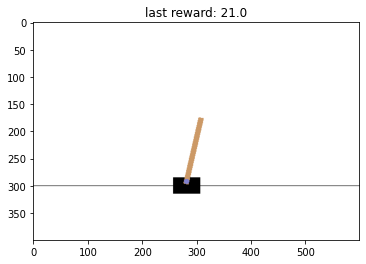

In [ ]:
import torch.nn as nn
from pandas_ml_quant_rl.model.agent import PolicyNetwork
from pandas_ml_quant_rl.model.agent import DQNAgent

class Net(PolicyNetwork):
    
    def __init__(self, input_size, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, n_actions),
        )
        
    def estimate_action(self, state, state_2):
        return self.net(state)



agent = DQNAgent(
    lambda: Net(env.observation_space.shape[0], 2).cpu(),
    exit_criteria=lambda reward, cnt: reward > 100 or cnt > 1500,
    batch_size=10,
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay = 0.998
)

agent.fit(env)

In [ ]:
IFrame('http://localhost:6006/', width='100%', height='800px')

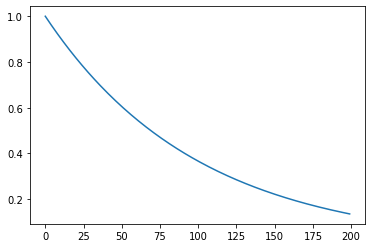

In [17]:
r = np.arange(200)
plt.plot(r, 0.99 ** r)